# Identify Growth Suburbs in Melbourne

Author: Yassin Eltahir    
Date: 2017-06-13

In [17]:
# Required Libraries
import pandas as pd
import numpy as np
import googlemaps
from sqlalchemy import create_engine
import yaml
from tqdm import tqdm
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt


#
init_notebook_mode()

# Source Config
conf = yaml.load(open('../conf.yaml','r'))
google_key = conf['google']['key']


# # Connect to DB
dbName = conf['db']['dbname']
user = conf['db']['username']
pwrd = conf['db']['password']
host = conf['db']['server']
port = conf['db']['port']
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(user, pwrd, host, port, dbName))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
# Source average price by property type for all melbourne records by month
qry_str = """

    SELECT price, date_trunc('month',date) as sale_month, prop_type
    FROM real_estate.auction_results
    WHERE city = 'melbourne'
      and result in ('S','SP','SA')

"""

melb_prices = pd.read_sql(qry_str, con = engine)

# Calculate Mean & Median for each month 
melb_price_agg = melb_prices.groupby(['sale_month','prop_type'])['price'].agg({'median_price':np.median, 'mean_price':np.mean, 'num_sales':len})
melb_price_agg.reset_index(inplace=True)

# Convert Month field to datetime
melb_price_agg['sale_month'] = pd.to_datetime(melb_price_agg.sale_month, utc = True)

## View Median Price by property type

In [16]:
# Plot Data
data = [go.Scatter(x = melb_price_agg[melb_price_agg.prop_type==prop_type].sale_month,
                   y=melb_price_agg[melb_price_agg.prop_type==prop_type].median_price,
                   name=prop_type
               ) for prop_type in melb_price_agg.prop_type.unique()]

# Plot Nicities
layout = go.Layout(
    title= 'Melbourne - Monthly Median Sale Price by Property Type',
    yaxis=dict(title='Median Price ($)'),
    xaxis=dict(title='Date')
    )
    
# Combine Plot & Formatting
fig = go.Figure(data=data, layout=layout)

# Generate Plot
# plot(fig, filename='test')
# iplot(fig)

from jupyterlab_plotly import Plotly
from IPython import display

Plotly(data, layout)

<jupyterlab_plotly.Plotly object>

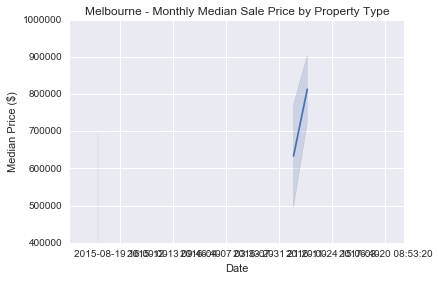

In [28]:
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

%matplotlib inline

ax = sns.tsplot(melb_price_agg,
               time = 'sale_month',
               value = 'median_price',
               unit = 'prop_type')

ax.set(xlabel='Date',
         ylabel='Median Price ($)',
         title='Melbourne - Monthly Median Sale Price by Property Type')



def myFormatter(x, pos):
    return pd.to_datetime(x)

ax.xaxis.set_major_formatter(FuncFormatter(myFormatter))

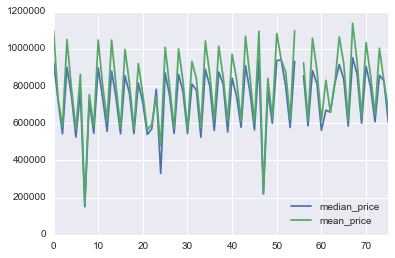

In [37]:
melb_price_agg.drop('num_sales',axis=1).plot()